## Imports

In [2]:
import matplotlib.pyplot as plt
import gymnasium as gym
import random
import math
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from tqdm import tqdm
from IPython.display import clear_output
from torch.distributions import Categorical
import numpy as np
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

## Prepare env

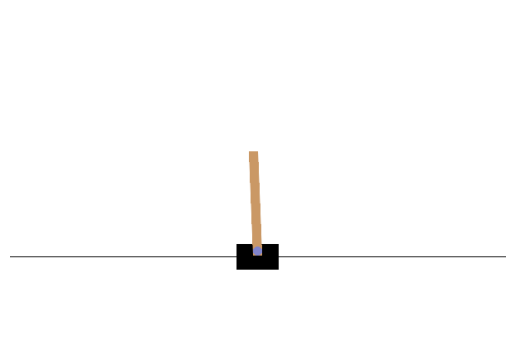

In [3]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
env.reset()
plt.imshow(env.render());
plt.axis("off");

In [5]:
env.reset()
done, terminated = False, False
step_i = 0

1.0 1 False False {}


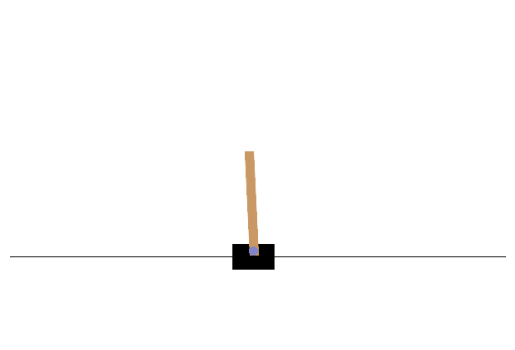

In [6]:
step_i += 1

action = env.action_space.sample()
state, reward, done, terminated, info = env.step(action)
print(reward, step_i, done, terminated, info)
plt.imshow(env.render());
plt.axis("off");

## Deep Q-Learning

### Replay buffer

In [ ]:
Transition = namedtuple("Transition", ("state", "action", "next_state", "reward"))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque([], maxlen=capacity)

    def store(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

### Network

In [ ]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 128)
        self.fc4 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

### Agent

In [ ]:
class Agent(object):
    def __init__(
        self,
        env,
        batch_size: int = 5,
        buffer_size: int = 1000,
        eps_start: float = 0.9,
        eps_end: float = 0.05,
        eps_decay: int = 1000,
        gamma: float = 0.99,
        tau: float = 0.005,
        lr: float = 1e-4,
    ):
        assert batch_size <= buffer_size, "batch_size must be equal or lower than buffer_size"
        
        self.env = env
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_decay = eps_decay
        self.batch_size = batch_size
        self.gamma = gamma
        self.tau = tau
        self.lr = lr
        self.loss = nn.MSELoss()
        
        n_actions = self.env.action_space.n
        n_observations = len(self.env.reset()[0])
        
        self.policy_net = DQN(n_observations, n_actions).to(device)
        self.target_net = DQN(n_observations, n_actions).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.memory = ReplayMemory(buffer_size)

        self.optimizer = optim.AdamW(self.policy_net.parameters(), lr=self.lr, amsgrad=True)

        self.steps_done = 0
        self.episode_durations = []
        

    def select_action(self, state):
        eps_threshold = (
            self.eps_end +
            (self.eps_start - self.eps_end) *
            math.exp(-1. * (self.steps_done / self.eps_decay))
        )

        self.steps_done += 1
        
        if random.random() > eps_threshold:
            with torch.no_grad():
                return self.policy_net(state).max(1).indices.view(1, 1)
        else:
            random_action = self.env.action_space.sample()
            return torch.tensor([[random_action]], device=device, dtype=torch.long)
        
    def play_episode(self, train=True):
        state, _ = self.env.reset()
        state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)


        for t in count():
            action = self.select_action(state)
            observation, reward, terminated, truncated, _ = self.env.step(action.item())

            reward = torch.tensor([reward], device=device)
            done = truncated or terminated

            if terminated:
                next_state = None
            else:
                next_state = torch.tensor(
                    observation,
                    dtype=torch.float32,
                    device=device
                ).unsqueeze(0)
            
            self.memory.store(state, action, next_state, reward)
            
            state = next_state

            if train:
                self.optimize_model()

                # Soft update of target network
                target_net_state_dict = self.target_net.state_dict()
                policy_net_state_dict = self.policy_net.state_dict()
                for key in policy_net_state_dict:
                    target_net_state_dict[key] += (
                        policy_net_state_dict[key] * self.tau -
                        target_net_state_dict[key] * self.tau
                    )
                self.target_net.load_state_dict(target_net_state_dict)
            else:
                self.render(t, done)  
            
            
            if done:
                if train:
                    self.episode_durations.append(t + 1)
                    self.plot_durations()
                break

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return
        
        # Sample random minibatch of transitions (s_i, a_i, r_i, s_i+1) from replay memory
        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))

        non_final_mask = torch.tensor(
            tuple(map(lambda s: s is not None, batch.next_state)),
            device=device,
            dtype=torch.bool
        )
        non_final_next_states = torch.cat(
            [s for s in batch.next_state if s is not None]
        )

        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        # Q-values of chosen actions in state
        q_pred = self.policy_net(state_batch).gather(1, action_batch)

        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(self.batch_size, device=device)
        with torch.no_grad():
            # V-func values for next non-final states
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1).values
        # Compute the expected Q-values
        q_target = (next_state_values * self.gamma) + reward_batch

        batch_loss = self.loss(q_pred, q_target.unsqueeze(1))

        self.optimizer.zero_grad()
        batch_loss.backward()

        self.optimizer.step()

    def render(self, t, done):
        clear_output(wait=True)
        
        plt.imshow(self.env.render())
        plt.pause(0.001)
        plt.xlabel(f"Timestep: {t}")
        plt.ylabel(f"{done}")

        

    def plot_durations(self, show_result=False):
        plt.figure(1)
        durations_t = torch.tensor(self.episode_durations, dtype=torch.float)
        if show_result:
            plt.title('Result')
        else:
            plt.clf()
            plt.title('Training...')
        plt.xlabel('Episode')
        plt.ylabel('Duration')
        plt.plot(durations_t.numpy())

        if len(durations_t) >= 100:
            means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
            means = torch.cat((torch.zeros(99), means))
            plt.plot(means.numpy())

        plt.pause(0.001)

        clear_output(wait=True)

    def train(self, num_episodes):
        for _ in range(num_episodes):
            self.play_episode(train=True)

    def test(self):
        self.play_episode(train=False)

In [611]:
agent = Agent(env, batch_size=200)

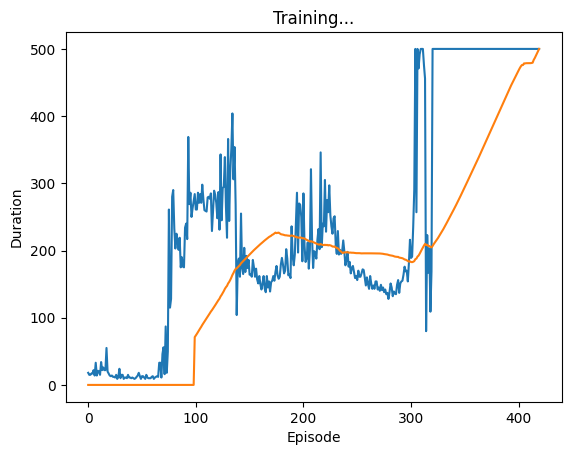

In [620]:
agent.train(100)

## Policy Gradient

In [61]:
class Policy(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        # return probs
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

In [62]:
p = Policy(4, 3, 10)

In [107]:
probs = torch.tensor([0.99, 0.0, 0.01])

In [108]:
Categorical(probs).sample()

tensor(0)

In [110]:
Categorical(probs).log_prob(torch.tensor(0))

tensor(-0.0101)

In [113]:
d = deque(maxlen=3)

In [121]:
d.append(7)
d

deque([3, 5, 7], maxlen=3)

In [122]:
d.pop()

7

In [ ]:
cartpole_hyperparameters = {
    "h_size": 16,
    "n_training_episodes": 1000,
    "n_evaluation_episodes": 10,
    "max_t": 1000,
    "gamma": 1.0,
    "lr": 1e-2,
    "env_id": env_id,
    "state_space": s_size,
    "action_space": a_size,
}

deque([3, 5], maxlen=3)

In [ ]:
class PolicyGradient:
    def __init__(
        self,
        env,
        h_size: int = 16,
        max_t: int = 1000,
        gamma: float = 1.0,
        lr: float = 1e-2,
    ) -> None:
        self.env = env
        
        self.action_space_n = self.env.action_space.n
        self.observation_space_n = len(self.env.reset()[0])
        
        self.h_size = h_size
        self.gamma = gamma
        self.lr = lr
        self.max_t = max_t
        
        self.policy = Policy(self.observation_space_n, self.action_space_n, self.h_size).to(device)

        self.training_scores = []
        self.optimizer = optim.Adam(params=self.policy.parameters(), lr=lr)

    def train(self, n_training_episodes = 1000, max_t = 1000):
        scores_deque = deque(maxlen=100)
        for i_episode in tqdm(range(1, n_training_episodes+1)):
            saved_log_probs = []
            rewards = []
            state, info = env.reset()

            for t in range(max_t):
                action, log_prob = self.policy.act(state=state)
                saved_log_probs.append(log_prob)
                state, reward, done, truncated, info = env.step(action)
                rewards.append(reward)
                if done or truncated:
                    break 
            scores_deque.append(sum(rewards))
            self.training_scores.append(sum(rewards))
            
            returns = deque(maxlen=max_t) 
            n_steps = len(rewards)

            for t in range(n_steps)[::-1]:
                disc_return_t = returns[0] if len(returns) > 0 else 0
                reward_t = rewards[t]
                returns.appendleft(reward_t + self.gamma * disc_return_t)

            eps = np.finfo(np.float32).eps.item()
            
            returns = torch.tensor(returns)
            returns = (returns - returns.mean()) / (returns.std() + eps)

            policy_loss = []
            for log_prob, disc_return in zip(saved_log_probs, returns):
                policy_loss.append(-log_prob * disc_return)
            policy_loss = torch.cat(policy_loss).sum()
            
            self.optimizer.zero_grad()
            policy_loss.backward()
            self.optimizer.step()
            
            if i_episode % 50 == 0:
                print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))

    def test(self, max_t = 1000):
        state, info = env.reset()
        done = False
        for t in range(max_t):
            self._render(t, done)
            action, _ = self.policy.act(state=state)
            new_state, _, done, truncated, _ = env.step(action)

            state = new_state
            if done or truncated:
                break 

    def _render(self, t, done):
        clear_output(wait=True)
        
        plt.imshow(self.env.render())
        plt.pause(0.001)
        plt.xlabel(f"Timestep: {t}")
        plt.ylabel(f"{done}")

In [205]:
pg = PolicyGradient(env=env)

100%|██████████| 50/50 [00:15<00:00,  3.29it/s]

Episode 50	Average Score: 212.84


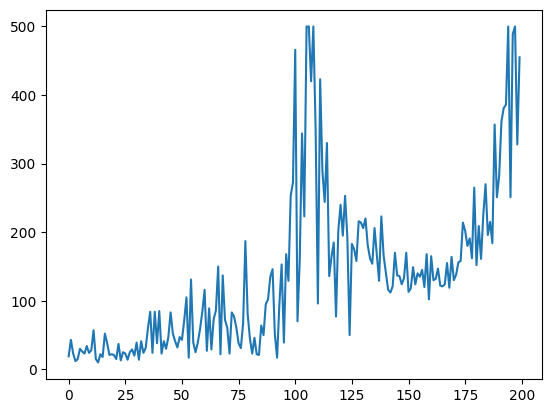

In [212]:
pg.train(n_training_episodes=50)
plt.plot(pg.training_scores)

## Advantage Actor Critic

In [225]:
class Actor(nn.Module):
    def __init__(self, s_size, a_size, h_size):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, a_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        m = Categorical(probs)
        action = m.sample()
        return action.item(), m.log_prob(action)

In [226]:
class Critic(nn.Module):
    def __init__(self, s_size, h_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(s_size, h_size)
        self.fc2 = nn.Linear(h_size, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
    
    def estimate(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        return probs

In [ ]:
class A2C:
    def __init__(
        self,
        env,
        h_size: int = 16,
        max_t: int = 500,
        gamma: float = 1.0,
        lr: float = 1e-2,
    ) -> None:
        self.env = env
        
        self.action_space_n = self.env.action_space.n
        self.observation_space_n = len(self.env.reset()[0])
        
        self.h_size = h_size
        self.gamma = gamma
        self.lr = lr
        self.max_t = max_t
        
        self.actor = Actor(self.observation_space_n, self.action_space_n, self.h_size).to(device)
        self.critic = Critic(self.observation_space_n, self.h_size).to(device)

        self.training_scores = []
        self.actor_opt = optim.Adam(params=self.actor.parameters(), lr=lr)
        self.critic_opt = optim.Adam(params=self.critic.parameters(), lr=lr)
        self.rewards = []

    def train(self, n_training_episodes = 1000, max_t = 1000):
        for i_episode in tqdm(range(n_training_episodes)):
            observation, _ = env.reset()
            
            actions_list = []
            log_probs_list = []
            states_list = []
            rewards_list = []
            
            ep_return = 0
            for t in range(max_t):
                action, log_prob = self.actor.act(state=observation)
                next_observation, reward, done, truncated, _ = env.step(action)

                actions_list.append(action)
                log_probs_list.append(log_prob)
                states_list.append(observation)
                rewards_list.append(reward)

                ep_return += reward
                observation = next_observation

                if done or truncated:
                    self.rewards.append(ep_return)
                    break 

            returns = self._calculate_returns(rewards_list)
            advantages = self._calculate_advantages(returns, states_list)

            self._update_actor(log_probs_list, advantages)
            self._update_critic(advantages)

            if ep_return > 450:
                break
            if (i_episode + 1) % 50 == 0:
                print('Episode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(self.rewards[-50:])))

    def _update_actor(self, log_probs_list, advantages):
        actor_loss = []
        for log_prob, advantage in zip(log_probs_list, advantages):
            actor_loss.append(-log_prob * advantage.detach())
        actor_loss = torch.cat(actor_loss).sum()
        
        self.actor_opt.zero_grad()
        actor_loss.backward()
        self.actor_opt.step()
    
    def _update_critic(self, advantages):
        critic_loss = []
        for advantage in advantages:
            critic_loss.append(advantage.pow(2))
        critic_loss = torch.cat(critic_loss).sum()
        self.critic_opt.zero_grad()
        critic_loss.backward()
        self.critic_opt.step()

    def _calculate_advantages(self, returns, states_list):
        advantages = []
        for t in range(len(states_list)):
            value = self.critic.estimate(states_list[t])
            advantages.append(returns[t] - value)
        return advantages

    def _calculate_returns(self, rewards_list):
        returns = deque(maxlen=len(rewards_list))
        for t in range(len(rewards_list))[::-1]:
            disc_return_t = returns[0] if len(returns) > 0 else 0
            reward_t = rewards_list[t]
            returns.appendleft(reward_t + self.gamma * disc_return_t)

        return returns


    def test(self, max_t = 1000):
        state, _ = env.reset()
        done = False
        for t in range(max_t):
            self._render(t, done)
            action, _ = self.actor.act(state=state)
            new_state, _, done, truncated, _ = env.step(action)

            state = new_state
            if done or truncated:
                break 
        self._render(max_t, done)

    def _render(self, t, done):
        clear_output(wait=True)
        
        plt.imshow(self.env.render())
        plt.pause(0.001)
        plt.xlabel(f"Timestep: {t}")
        plt.ylabel(f"{done}")

In [220]:
a2c = A2C(env)

In [221]:
a2c.train(500)

 10%|█         | 50/500 [00:05<01:01,  7.29it/s]

Episode 49	Average Score: 34.94


 20%|██        | 100/500 [00:22<03:20,  2.00it/s]

Episode 99	Average Score: 130.50


 30%|███       | 150/500 [00:39<02:09,  2.69it/s]

Episode 149	Average Score: 140.40


 33%|███▎      | 166/500 [00:51<01:42,  3.25it/s]


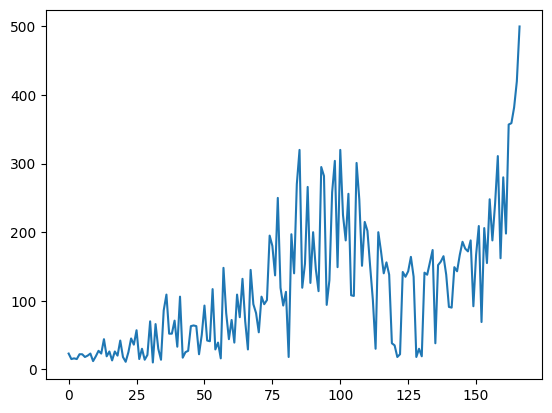

In [222]:
plt.plot(a2c.rewards)